In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [28]:
model = None

def clean_ids(df, col_name):
    # 1. Force to numeric, turning errors (like strings "Main Hall") into NaN
    # 2. Fill NaNs with 0 (or -1) so we can convert to integer
    # 3. Convert to integer (removes the .0)
    # 4. Convert to string
    return (pd.to_numeric(df[col_name], errors='coerce')
            .fillna(0)
            .astype(int)
            .astype(str))

def train_and_predict_demand(df_meter, df_weather, target_sims_code, future_hours=24):
    print(f"--- Training Forecast Model for Building {target_sims_code} ---")
    
    # 1. PREPARE METER DATA
    # Filter for specific building and utility (POWER for demand, ELECTRICITY if kWh)
    # We prioritize 'ELECTRICAL_POWER' (kW), but fallback to 'ELECTRICITY' (kWh)
    
    # Apply to both dataframes before merging
    df_meter['simscode_clean'] = clean_ids(df_meter, 'simscode')
    df_meter['buildingnumber_clean'] = clean_ids(df_meter, 'buildingnumber')

    df_bldg = df_meter[
        (df_meter['simscode_clean'] == str(target_sims_code)) & 
        (df_meter['utility'].isin(['ELECTRICAL_POWER', 'ELECTRICITY']))
    ].copy()
    
    if df_bldg.empty:
        print("Error: No data found for this building/utility.")
        return None

    # Handle timestamps
    df_bldg['readingtime'] = pd.to_datetime(df_bldg['readingtime'])
    df_bldg = df_bldg.sort_values('readingtime')
    
    # Aggregate to hourly (just in case data is 15-min interval)
    # This aligns with the hourly weather data
    df_hourly = df_bldg.set_index('readingtime').resample('h')['readingvalue'].mean().reset_index()

    # 2. MERGE WITH WEATHER
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    # Merge on nearest hour
    df_merged = pd.merge_asof(
        df_hourly, 
        df_weather[['date', 'temperature_2m', 'relative_humidity_2m']],
        left_on='readingtime',
        right_on='date',
        direction='nearest'
    )

    # 3. FEATURE ENGINEERING
    df = df_merged.copy()
    
    # Time Features
    df['hour'] = df['readingtime'].dt.hour
    df['dayofweek'] = df['readingtime'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # Lag Features (The "Auto-Regressive" part)
    # "Value 24 hours ago" is a massive predictor
    df['lag_24h'] = df['readingvalue'].shift(24)
    df['lag_168h'] = df['readingvalue'].shift(168) # Same time last week
    
    # Drop NAs created by lags
    df = df.dropna()

    # 4. TRAIN/TEST SPLIT
    # We can't shuffle time series! We split by time.
    # Training: All data except last 24 hours
    # Testing: The last 24 hours (to validate accuracy)
    split_point = len(df) - 24
    train = df.iloc[:split_point]
    test = df.iloc[split_point:]

    features = ['hour', 'dayofweek', 'is_weekend', 'temperature_2m', 'lag_24h']
    target = 'readingvalue'

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # 5. MODEL TRAINING (XGBoost)
    model = xgb.XGBRegressor(
        n_estimators=5000,
        learning_rate=0.05,
        early_stopping_rounds=50
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    # 6. EVALUATION
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"Model Performance (MAE): {mae:.2f} kW")
    
    # 7. FUTURE PREDICTION (Next 24 Hours)
    # To predict the REAL future, you'd need the *forecasted* weather.
    # Here, we demonstrate simply plotting the test validation.
    
    plt.figure(figsize=(12, 6))
    plt.plot(test['readingtime'], y_test, label='Actual Demand')
    plt.plot(test['readingtime'], predictions, label='Predicted Demand', linestyle='--')
    plt.title(f"24-Hour Power Demand Forecast: Building {target_sims_code}")
    plt.xlabel("Time")
    plt.ylabel("kW")
    plt.legend()
    plt.savefig('forecast_plot.png')
    print("Forecast plot saved as 'forecast_plot.png'")
    
    return model, predictions

In [4]:
meter_readings = pd.read_csv('./master_dataset_combined.csv')
weather_data = pd.read_csv('./energy_dataset/advanced_core/weather_data_hourly_2025.csv')

In [26]:
meter_readings.head()

,meterid,siteid,sitename,simscode,utility,readingtime,readingvalue,readingunits,readingunitsdisplay,readingwindowstart,...,formalname,alsoknownas,grossarea,floorsaboveground,floorsbelowground,constructiondate,latitude,longitude,simscode_clean,buildingnumber_clean
0,246529,44236,Longaberger Alumni House,22.0,GAS,2025-08-01T05:00:00,22.194084,kWh,Kilowatt hour,2025-08-01T05:00:00,...,Longaberger Alumni House,NaN,56976.0,4.0,1.0,1999-07-01,40.008801,-83.021294,22,22
1,247273,44131,Recreation and Physical Activity Center,246.0,COOLING,2025-08-01T05:00:00,NaN,kWh,Kilowatt hour,2025-08-01T05:00:00,...,Recreation and Physical Activity Center,RPAC,279856.0,5.0,0.0,2005-07-01,39.999510,-83.018380,246,246
2,247290,44158,Torres House,1101.0,COOLING,2025-08-01T05:00:00,45.657477,kWh,Kilowatt hour,2025-08-01T05:00:00,...,Torres House,"NRDT A, Building A - North Residential",127073.0,9.0,0.0,2015-07-01,40.005951,-83.013655,1101,1101
3,246094,44055,Goss Laboratory,180.0,ELECTRICITY,2025-08-01T05:00:00,12.914948,kWh,Kilowatt hour,2025-08-01T05:00:00,...,"Goss, Leonard W, Laboratory",Veterinary,67943.0,4.0,0.0,1962-07-01,39.999997,-83.027551,180,180
4,246515,44078,Knowlton Hall,17.0,GAS,2025-08-01T05:00:00,0.000000,kWh,Kilowatt hour,2025-08-01T05:00:00,...,"Knowlton, Austin E, Hall","Architecture, Brown Hall, Ives",174422.0,6.0,0.0,2004-07-01,40.003599,-83.016789,17,17


In [20]:
a2 = meter_readings.iloc[meter_readings['sitename'] == 'Dreese Laboratories']

In [14]:
a = [b for b in list(meter_readings['sitename']) if 'Dreese' in b]

--- Training Forecast Model for Building 246 ---
Model Performance (MAE): 2.90 kW
Forecast plot saved as 'forecast_plot.png'


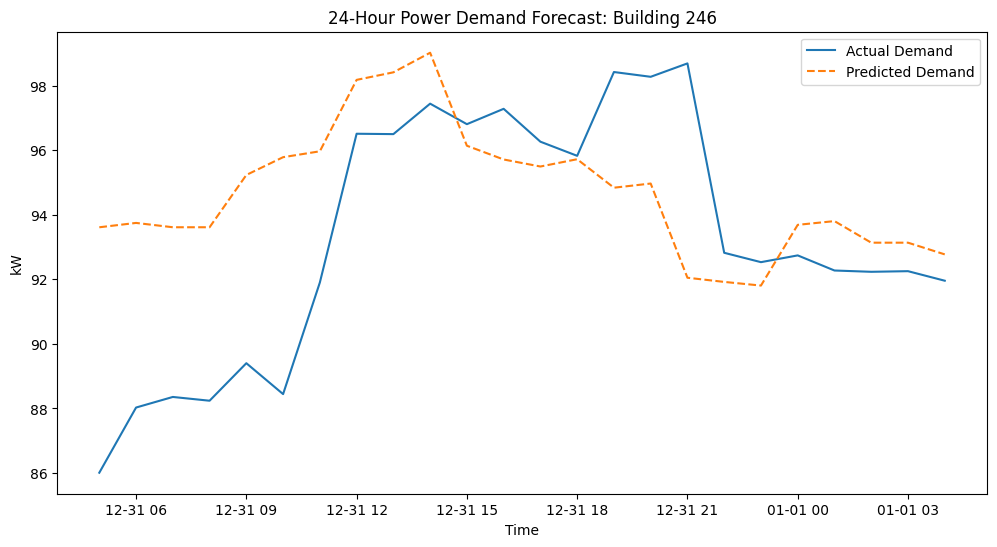

In [29]:
# 1. Pick a building (e.g., '279' is Dreese Labs)
model, preds = train_and_predict_demand(meter_readings, weather_data, target_sims_code='246')